In [2]:
#import the libraries we may use
import numpy as np
import pandas as pd
import pickle
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

In [3]:
#use the dataset stored in a pickle file
with open('song_df_aggregate.pkl', 'rb') as f:
        df = pickle.load(f)

In [4]:
#we select only songs released before the 2019-10-5
#and to use first rank, we delete the songs which first rank is inferior to 10 to avoid leakage
dataset=df[df.date<"2019-10-05"][df.firstrank>10]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
#we delete rows with NaN on those columns
#due to spotify's lack of information on some songs 

nan_col=["spotify_duration_ms","spotify_track_number","spotify_danceability","spotify_energy","spotify_loudness",
            "spotify_mode","spotify_speechiness","spotify_acousticness","spotify_instrumentalness",
           "spotify_liveness","spotify_valence","spotify_tempo","spotify_time_signature","artist_has_award"]

dataset=dataset.dropna(axis=0,subset=nan_col)

In [6]:
#delete unuseful features
dataset=dataset.drop(["release_year","label_category","artist","title","spotify_album_id",
                      "spotify_album_release_date_precision","album_label","datetime","join",
                      "spotify_id","spotify_disc_number","spotify_album_release_date","spotify_key",
                      "top50","top25","top75","top5","spotify_album_release_date_datetime",
                      "first_date","datetime","isnew","rank","release_month","last_award_type","label_appearance_count","label_appearance_count_group","numberofappearances"],axis=1)

In [7]:
#summary of the dataset infos
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7889 entries, 174 to 8518
Data columns (total 30 columns):
date                                7889 non-null object
spotify_explicit                    7889 non-null object
spotify_duration_ms                 7889 non-null float64
spotify_track_number                7889 non-null float64
spotify_danceability                7889 non-null float64
spotify_energy                      7889 non-null float64
spotify_loudness                    7889 non-null float64
spotify_mode                        7889 non-null float64
spotify_speechiness                 7889 non-null float64
spotify_acousticness                7889 non-null float64
spotify_instrumentalness            7889 non-null float64
spotify_liveness                    7889 non-null float64
spotify_valence                     7889 non-null float64
spotify_tempo                       7889 non-null float64
spotify_time_signature              7889 non-null float64
num_artists            

In [8]:
#train and test set split
test_set=dataset[dataset.date>="2016-06-11"]
train_set=dataset[dataset.date<"2016-06-11"]

In [9]:
len(test_set)/len(dataset)

0.2030675624286982

In [10]:
ytrain=train_set["top10"]
ytest=test_set["top10"]
train=train_set.drop(["date","bestrank"],axis=1)
test=test_set.drop(["date","top10","bestrank"],axis=1)

In [11]:
#we encode the categorical variables 
le = preprocessing.LabelEncoder()
train['label_category_group'] = le.fit_transform(train['label_category_group'].astype(str))
train['album_type'] = le.fit_transform(train['album_type'].astype(str))
train['spotify_explicit'] = le.fit_transform(train['spotify_explicit'].astype(str))
train["datetime_year"]=le.fit_transform(train["datetime_year"])
train["datetime_month"]=le.fit_transform(train["datetime_month"])
train["top10"]=le.fit_transform(train["top10"])

test['label_category_group'] = le.fit_transform(test['label_category_group'].astype(str))
test['album_type'] = le.fit_transform(test['album_type'].astype(str))
test["datetime_year"]=le.fit_transform(test["datetime_year"])
test["datetime_month"]=le.fit_transform(test["datetime_month"])
test['spotify_explicit'] = le.fit_transform(test['spotify_explicit'].astype(str))

ytrain=pd.DataFrame(le.fit_transform(ytrain),columns=["top10"])
ytest=pd.DataFrame(le.fit_transform(ytest),columns=["top10"])

In [15]:
#we use here again the SMOTE technique to balance our dataset

from imblearn.over_sampling import SMOTE
y=ytrain.values.reshape((-1,)) #shape needed for SMOTE
train.columns = train.columns.str.strip()
sm = SMOTE(random_state=42)
train, ytrain = sm.fit_resample(train,y)

Using TensorFlow backend.


In [16]:
len(train)

10940

In [17]:
train=train.drop(["top10"],axis=1)

In [12]:
#CV to fine tune the parameters

param_grid = {
    'min_samples_split': [2, 3, 4,5], 
    'n_estimators' : [50,60,70],
    'max_depth': [15, 20, 25],
    'max_features': [ 12, 15, 18, 20],
    'min_samples_leaf': [2, 4, 6],
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'accuracy_score': make_scorer(accuracy_score),
    'recall_score': make_scorer(recall_score)
}


In [13]:
#to take into account the fact that we are dealing with ordinal variables, we'll use an ordinal LogReg
from mord import LogisticAT
model_ordinal = LogisticAT()
param_grid_ord={
    'alpha': [0.1, 0.3, 0.4,0.5,0.7,0.9,1,1.5,2,5], 
}


def grid_search_wrapper_ord(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10) #The folds are made by preserving the percentage of samples for each class.
    grid_search_ord = GridSearchCV(model_ordinal, param_grid_ord, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search_ord.fit(train, ytrain)

    # make the predictions
    y_pred = grid_search_ord.predict(test)

    print('Best params for {}'.format(refit_score))
    print(grid_search_ord.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(ytest, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search_ord


In [18]:
mod_ord=grid_search_wrapper_ord()

Best params for precision_score
{'alpha': 0.5}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg      1104       402
pos        49        47


In [19]:
ypred_ord=mod_ord.predict_proba(test)

Accuracy of Ordinal Logistic regression classifier on test set: 0.10


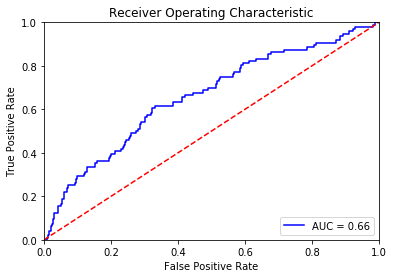

In [20]:
#ROC ordinal LogReg
import sklearn.metrics as metrics

a = mod_ord.predict_proba(test)
lr_probs = a[:,1]
print('Accuracy of Ordinal Logistic regression classifier on test set: {:.2f}'.format(mod_ord.score(test, ytest)))

fpr, tpr, threshold = metrics.roc_curve(ytest, lr_probs)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("Logisticregression")
plt.show()

In [21]:
#confusion matrix 
pred_ord=[]
count=0
for proba in ypred_ord[:,1]:
    if proba>0.75:
            pred_ord.append(1)
            count+=1
    else:
        pred_ord.append(0)

In [22]:
print(confusion_matrix(ytest,pred_ord))

[[1423   83]
 [  78   18]]


Bootstrap

In [23]:
toto = test.copy()
toto["top10"]= ytest.values

In [24]:
from sklearn.utils import resample

stats = list()
df = test.copy()

for i in range(1000):
    boot = resample(toto, replace=True, n_samples=10000)
    boot_y = boot.pop("top10")
    ypred_ord=mod_ord.predict_proba(boot)
    pred_ord=[]
    count=0
    for proba in ypred_ord[:,1]:
        if proba>0.75:
                pred_ord.append(1)
                count+=1
        else:
            pred_ord.append(0)
    
    confusion_matrix(boot_y,pred_ord)
    
    precision = (confusion_matrix(boot_y,pred_ord)[1][1]) / (confusion_matrix(boot_y,pred_ord)[1][1] + confusion_matrix(boot_y,pred_ord)[0][1]) 
    stats.append(precision)

In [25]:
import matplotlib.pyplot as plt

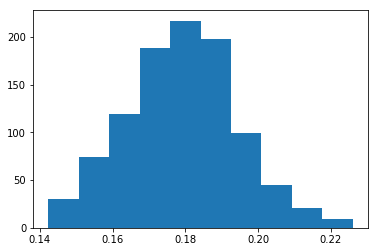

95.0 confidence interval 15.0% and 21.1%


In [26]:
# plot scores
plt.hist(stats)
plt.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))